In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [191]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
#         self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.scaler = nn.Parameter(torch.Tensor([1.0]))
#         self.layernorm = nn.LayerNorm(num_centers)
        
    def forward(self, x):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        
        ### normalize similar to UMAP
        dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        dists = dists/dists.std(dim=1, keepdim=True)

#         dists = self.layernorm(dists)

#         dists = torch.exp(-dists*self.scaler)
#         dists = torch.softmax(-dists*self.scaler, dim=1)
        
        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass

In [192]:
dt = DistanceTransform(784, 20)

In [193]:
dists = dt(torch.randn(2, 784))

In [194]:
dists.shape

torch.Size([2, 20])

In [195]:
dt.set_centroid_to_data_randomly(train_loader)

In [196]:
# dt.set_centroid_to_data(train_loader)

In [197]:
### distance vs matrix multiplication time

In [198]:
N = 784
M = 784
A = torch.randn(N, M)

In [199]:
torch.cdist(data, data)

tensor([[0.0000e+00, 4.1089e+01, 4.0059e+01,  ..., 3.9491e+01, 4.0451e+01,
         3.9239e+01],
        [4.1089e+01, 0.0000e+00, 4.0618e+01,  ..., 4.0096e+01, 3.9938e+01,
         3.9485e+01],
        [4.0059e+01, 4.0618e+01, 0.0000e+00,  ..., 4.1031e+01, 4.0741e+01,
         3.8763e+01],
        ...,
        [3.9491e+01, 4.0096e+01, 4.1031e+01,  ..., 1.1049e-02, 3.8735e+01,
         3.7855e+01],
        [4.0451e+01, 3.9938e+01, 4.0741e+01,  ..., 3.8735e+01, 1.1049e-02,
         3.9317e+01],
        [3.9239e+01, 3.9485e+01, 3.8763e+01,  ..., 3.7855e+01, 3.9317e+01,
         0.0000e+00]])

In [200]:
# %timeit torch.cdist(data, data)

14.6 ms ± 4.51 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [201]:
# %timeit torch.matmul(data, data)

8.71 ms ± 666 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [202]:
#######################

In [208]:
model = nn.Sequential(
                DistanceTransform(784, 785),
                nn.BatchNorm1d(785),
                nn.LeakyReLU(),
                DistanceTransform(785, 200),
                nn.BatchNorm1d(200),
                nn.LeakyReLU(),
                DistanceTransform(200, 50),
                nn.BatchNorm1d(50),
                nn.LeakyReLU(),
                DistanceTransform(50, 10),
                nn.BatchNorm1d(10)
            )
model.to(device)

Sequential(
  (0): DistanceTransform()
  (1): BatchNorm1d(785, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): DistanceTransform()
  (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): DistanceTransform()
  (7): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): DistanceTransform()
  (10): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [209]:
# model[0].centers.requires_grad=False
# model[0].set_centroid_to_data_randomly(train_loader) ## this worked best for preserving locality
# model[0].set_centroid_to_data_maxdist(train_loader)

In [210]:
center_lbl = model(model[0].centers.data)
output_cent = torch.softmax(center_lbl, dim=1).argmax(dim=1).data.cpu()
torch.unique(output_cent, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 56,  85,  86,  72,  71, 100,  69, 103,  77,  66]))

In [211]:
optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.0003, weight_decay=1e-15)
criterion = nn.CrossEntropyLoss()

In [212]:
index = 0
train_accs, test_accs = [], []
for epoch in tqdm(list(range(40))):
    model.train()
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0
    
#     if epoch%5 == 0:
#         print(f"Shifting the centroids to the nearest data point")
#         model[0].set_centroid_to_data(train_loader)

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    model.eval()
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:0.74932461977005


  2%|▎         | 1/40 [01:16<49:36, 76.32s/it]

Train Acc:74.18%, Test Acc:82.54%

Epoch: 1:0,  Loss:0.47134920954704285


  5%|▌         | 2/40 [02:13<41:19, 65.24s/it]

Train Acc:82.52%, Test Acc:84.89%

Epoch: 2:0,  Loss:0.5505233407020569


  8%|▊         | 3/40 [03:32<44:02, 71.42s/it]

Train Acc:84.37%, Test Acc:85.57%

Epoch: 3:0,  Loss:0.3759661614894867


 10%|█         | 4/40 [04:30<39:37, 66.03s/it]

Train Acc:85.82%, Test Acc:86.64%

Epoch: 4:0,  Loss:0.38026049733161926


 12%|█▎        | 5/40 [05:14<33:54, 58.12s/it]

Train Acc:86.61%, Test Acc:87.01%

Epoch: 5:0,  Loss:0.4230002164840698


 15%|█▌        | 6/40 [05:56<29:46, 52.54s/it]

Train Acc:87.18%, Test Acc:87.19%

Epoch: 6:0,  Loss:0.4185982942581177


 18%|█▊        | 7/40 [06:36<26:44, 48.61s/it]

Train Acc:87.84%, Test Acc:87.42%

Epoch: 7:0,  Loss:0.30227741599082947


 20%|██        | 8/40 [07:35<27:43, 51.98s/it]

Train Acc:88.52%, Test Acc:87.43%

Epoch: 8:0,  Loss:0.2148171365261078


 22%|██▎       | 9/40 [08:16<24:57, 48.32s/it]

Train Acc:89.02%, Test Acc:87.80%

Epoch: 9:0,  Loss:0.28423935174942017


 25%|██▌       | 10/40 [09:05<24:21, 48.73s/it]

Train Acc:89.52%, Test Acc:88.04%

Epoch: 10:0,  Loss:0.30327168107032776


 28%|██▊       | 11/40 [09:56<23:52, 49.41s/it]

Train Acc:90.06%, Test Acc:88.30%

Epoch: 11:0,  Loss:0.4256718158721924


 30%|███       | 12/40 [11:04<25:35, 54.85s/it]

Train Acc:90.35%, Test Acc:88.34%

Epoch: 12:0,  Loss:0.2587803900241852


 32%|███▎      | 13/40 [11:48<23:17, 51.74s/it]

Train Acc:90.76%, Test Acc:88.39%

Epoch: 13:0,  Loss:0.2891448736190796


 35%|███▌      | 14/40 [12:35<21:50, 50.41s/it]

Train Acc:91.32%, Test Acc:88.48%

Epoch: 14:0,  Loss:0.32807496190071106


 38%|███▊      | 15/40 [13:19<20:05, 48.24s/it]

Train Acc:91.42%, Test Acc:88.47%

Epoch: 15:0,  Loss:0.3048734962940216


 40%|████      | 16/40 [14:02<18:42, 46.79s/it]

Train Acc:91.88%, Test Acc:88.08%

Epoch: 16:0,  Loss:0.1748654693365097


 42%|████▎     | 17/40 [14:46<17:32, 45.78s/it]

Train Acc:92.37%, Test Acc:88.58%

Epoch: 17:0,  Loss:0.14756596088409424


 45%|████▌     | 18/40 [15:30<16:41, 45.52s/it]

Train Acc:92.61%, Test Acc:88.68%

Epoch: 18:0,  Loss:0.09920892864465714


 48%|████▊     | 19/40 [16:42<18:38, 53.28s/it]

Train Acc:92.92%, Test Acc:88.70%

Epoch: 19:0,  Loss:0.2741920053958893


 50%|█████     | 20/40 [17:38<18:00, 54.04s/it]

Train Acc:93.08%, Test Acc:88.55%

Epoch: 20:0,  Loss:0.2995374798774719


 52%|█████▎    | 21/40 [18:54<19:15, 60.84s/it]

Train Acc:93.46%, Test Acc:88.33%

Epoch: 21:0,  Loss:0.11350921541452408


 55%|█████▌    | 22/40 [20:05<19:10, 63.93s/it]

Train Acc:93.88%, Test Acc:88.85%

Epoch: 22:0,  Loss:0.18377938866615295


 57%|█████▊    | 23/40 [21:18<18:51, 66.55s/it]

Train Acc:93.82%, Test Acc:88.88%

Epoch: 23:0,  Loss:0.06999945640563965


 60%|██████    | 24/40 [22:27<17:54, 67.15s/it]

Train Acc:94.20%, Test Acc:88.55%

Epoch: 24:0,  Loss:0.1003730297088623


 62%|██████▎   | 25/40 [23:39<17:12, 68.84s/it]

Train Acc:94.36%, Test Acc:88.74%

Epoch: 25:0,  Loss:0.07631047070026398


 65%|██████▌   | 26/40 [24:46<15:55, 68.25s/it]

Train Acc:94.79%, Test Acc:88.52%

Epoch: 26:0,  Loss:0.15167157351970673


 68%|██████▊   | 27/40 [25:56<14:52, 68.67s/it]

Train Acc:94.66%, Test Acc:88.25%

Epoch: 27:0,  Loss:0.09042808413505554


 70%|███████   | 28/40 [27:04<13:41, 68.44s/it]

Train Acc:94.96%, Test Acc:88.59%

Epoch: 28:0,  Loss:0.2250058799982071


 72%|███████▎  | 29/40 [28:16<12:45, 69.58s/it]

Train Acc:95.11%, Test Acc:88.91%

Epoch: 29:0,  Loss:0.19811053574085236


 75%|███████▌  | 30/40 [29:23<11:27, 68.78s/it]

Train Acc:95.16%, Test Acc:88.48%

Epoch: 30:0,  Loss:0.08220035582780838


 78%|███████▊  | 31/40 [30:34<10:24, 69.42s/it]

Train Acc:95.38%, Test Acc:88.33%

Epoch: 31:0,  Loss:0.2943872809410095


 80%|████████  | 32/40 [31:45<09:19, 69.97s/it]

Train Acc:95.58%, Test Acc:88.61%

Epoch: 32:0,  Loss:0.11965968459844589


 82%|████████▎ | 33/40 [32:52<08:03, 69.09s/it]

Train Acc:95.74%, Test Acc:88.69%

Epoch: 33:0,  Loss:0.05170389637351036


 85%|████████▌ | 34/40 [33:45<06:24, 64.10s/it]

Train Acc:95.81%, Test Acc:88.71%

Epoch: 34:0,  Loss:0.09556663781404495


 88%|████████▊ | 35/40 [34:37<05:02, 60.54s/it]

Train Acc:96.03%, Test Acc:88.82%

Epoch: 35:0,  Loss:0.059252262115478516


 90%|█████████ | 36/40 [35:34<03:57, 59.41s/it]

Train Acc:96.14%, Test Acc:88.32%

Epoch: 36:0,  Loss:0.252322793006897


 92%|█████████▎| 37/40 [36:37<03:01, 60.59s/it]

Train Acc:96.16%, Test Acc:89.00%

Epoch: 37:0,  Loss:0.11021409183740616


 95%|█████████▌| 38/40 [37:42<02:04, 62.03s/it]

Train Acc:96.25%, Test Acc:88.87%

Epoch: 38:0,  Loss:0.11890698224306107


 98%|█████████▊| 39/40 [38:46<01:02, 62.55s/it]

Train Acc:96.37%, Test Acc:89.06%

Epoch: 39:0,  Loss:0.08252234756946564


100%|██████████| 40/40 [39:49<00:00, 59.75s/it]

Train Acc:96.57%, Test Acc:88.68%

	-> MAX Train Acc 96.57 ; Test Acc 89.05999999999999


In [190]:
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

	-> MAX Train Acc 96.785 ; Test Acc 89.18


In [119]:
# torch.save(model.state_dict(), "./temp_01_2_model_nov26.pth")
torch.save(model.state_dict(), "./temp_03_1_model_nov26_v0.pth")

# model.load_state_dict(torch.load("./temp_01_2_model_nov26.pth", map_location=device))

In [213]:
model.eval()
xx = train_dataset[np.random.randint(0, len(train_dataset), 50)][0].to(device)
dists = model[0](xx)
# dists = model[1](dists)
model.train()
dists.shape

torch.Size([50, 785])

In [214]:
dists.mean(), dists.std(), dists.max(dim=1)

(tensor(3.5557, grad_fn=<MeanBackward0>),
 tensor(1.0201, grad_fn=<StdBackward0>),
 torch.return_types.max(values=tensor([6.7112, 5.5499, 6.3170, 5.8182, 6.3306, 5.8378, 5.8608, 5.9684, 5.9537,
        5.8157, 6.0797, 6.5277, 5.6916, 6.0367, 6.0768, 6.2349, 5.8488, 5.9572,
        5.9595, 6.3411, 5.9015, 6.3018, 6.4121, 6.3000, 6.1324, 6.2472, 6.0858,
        6.3723, 6.7114, 5.7186, 5.7301, 6.4065, 6.0267, 5.8675, 5.9568, 6.0620,
        6.1567, 6.4980, 5.8517, 6.0794, 6.0774, 5.8350, 6.2789, 6.3009, 6.0523,
        6.2202, 5.6946, 6.2313, 6.2099, 6.0226], grad_fn=<MaxBackward0>), ...))

In [215]:
model[0].scaler

Parameter containing:
tensor([1.], requires_grad=True)

## UMAP - from library

In [216]:
import umap

In [217]:
embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [218]:
center_lbl = model(model[0].centers.data)
output_cent = torch.softmax(center_lbl, dim=1).argmax(dim=1).data.cpu()
# output_cent = center_lbl.data.cpu().numpy()

torch.unique(output_cent, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([76, 85, 72, 97, 63, 83, 79, 57, 90, 83]))

In [219]:
centers = model[0].centers.data.cpu().numpy()

embedding = embed.fit_transform(centers)
# embedding = embed.fit_transform(centers, output_cent)

In [220]:
i = 0

In [221]:
activ.max()

tensor(0.0411)

42/50


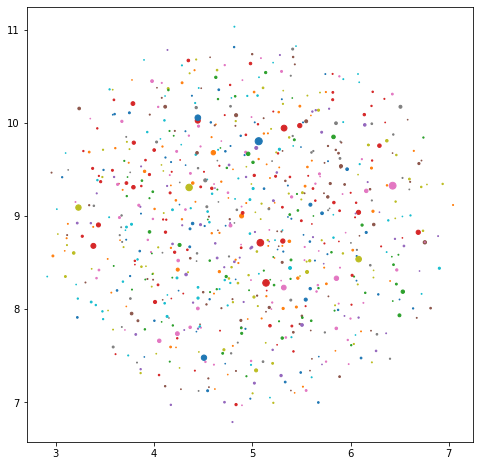

In [266]:
activ = dists.data.cpu()[i]
activ = activ - activ.min()
activ = torch.exp(-activ)

i += 1
print(f"{i}/{len(dists)}")
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*50, 0.5), cmap="tab10")

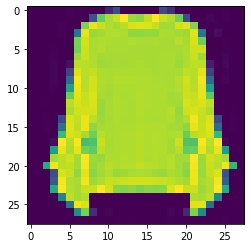

In [958]:
plt.imshow(xx.cpu()[i].reshape(28,28))

## TSNE

In [173]:
from sklearn.manifold import TSNE

In [174]:
tsne = TSNE(n_components=2)
embt = tsne.fit_transform(centers)

In [175]:
embt

array([[-0.5517291 , -1.0944433 ],
       [ 3.3717325 , -0.56145626],
       [ 0.6929321 , -1.2497946 ],
       ...,
       [ 0.15066037,  1.6854407 ],
       [ 3.8948274 ,  1.1707855 ],
       [ 3.5280528 , -0.13315178]], dtype=float32)

In [176]:
i = 0

5/50


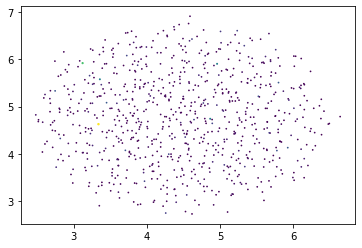

In [182]:
activ = dists.data.cpu()[i]
# activ = activ - activ.min()
# activ = torch.exp(-activ)
print(f"{i}/{len(dists)}")
i += 1
# plt.scatter(embt[:,0], embt[:, 1], c=activ, marker=".")
plt.scatter(embedding[:,0], embedding[:, 1], c=activ, s=np.maximum(activ*50, 0.5))#, cmap="Greys")

### Centroid Visualization